# Adversarial Attack Project (FGSM + PGD on CIFAR-10)

This notebook implements an **Adversarial Attack** project on CIFAR-10 using a Convolutional Neural Network (CNN).

We:
- Train a CNN on CIFAR-10 and report **clean test accuracy**.
- Implement **FGSM** and **PGD** adversarial attacks.
- Compute **Attack Success Rate (ASR)** for both attacks.
- Perform **advanced evaluation** by varying ε and PGD steps.
- Visualize **clean vs adversarial images**.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


## 1. CIFAR-10 Dataset and DataLoaders

In [2]:
# Standard CIFAR-10 normalization
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train
)
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test
)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

class_names = trainset.classes
print("Classes:", class_names)


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## 2. CNN Model (SimpleCNN)

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 16x16

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 8x8

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 4x4
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN().to(device)
print(model)


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)


## 3. Training the CNN on CIFAR-10

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

num_epochs = 40  # you can increase this if you have time / GPU

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f} - Acc: {epoch_acc*100:.2f}%")

print("Training complete.")


Epoch [1/40] - Loss: 1.8277 - Acc: 32.36%
Epoch [2/40] - Loss: 1.4141 - Acc: 48.48%
Epoch [3/40] - Loss: 1.2100 - Acc: 56.60%
Epoch [4/40] - Loss: 1.0597 - Acc: 62.38%
Epoch [5/40] - Loss: 0.9517 - Acc: 66.45%
Epoch [6/40] - Loss: 0.8787 - Acc: 69.07%
Epoch [7/40] - Loss: 0.8230 - Acc: 71.26%
Epoch [8/40] - Loss: 0.7741 - Acc: 72.90%
Epoch [9/40] - Loss: 0.7380 - Acc: 74.08%
Epoch [10/40] - Loss: 0.7049 - Acc: 75.45%
Epoch [11/40] - Loss: 0.6773 - Acc: 76.21%
Epoch [12/40] - Loss: 0.6532 - Acc: 77.30%
Epoch [13/40] - Loss: 0.6311 - Acc: 77.82%
Epoch [14/40] - Loss: 0.6094 - Acc: 78.67%
Epoch [15/40] - Loss: 0.5904 - Acc: 79.31%
Epoch [16/40] - Loss: 0.5665 - Acc: 80.06%
Epoch [17/40] - Loss: 0.5587 - Acc: 80.45%
Epoch [18/40] - Loss: 0.5435 - Acc: 80.99%
Epoch [19/40] - Loss: 0.5277 - Acc: 81.51%
Epoch [20/40] - Loss: 0.5212 - Acc: 81.82%
Epoch [21/40] - Loss: 0.4992 - Acc: 82.57%
Epoch [22/40] - Loss: 0.4885 - Acc: 82.75%
Epoch [23/40] - Loss: 0.4800 - Acc: 83.28%
Epoch [24/40] - Loss

## 4. Evaluation on Clean Test Data

In [5]:
def evaluate_clean_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    print(f"Clean test accuracy: {acc * 100:.2f}%")
    return acc

clean_acc = evaluate_clean_accuracy(model, testloader, device)


Clean test accuracy: 83.92%


## 5. FGSM Attack

In [8]:
def fgsm_attack(model, images, labels, epsilon):
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    images.requires_grad = True

    outputs = model(images)
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()

    data_grad = images.grad.data
    perturbed_images = images + epsilon * data_grad.sign()
    perturbed_images = torch.clamp(perturbed_images, -2.5, 2.5)  # keep in a safe range
    return perturbed_images.detach()


### 5.1 FGSM – Basic Evaluation and Attack Success Rate (ASR)

In [9]:
def evaluate_fgsm_attack(model, dataloader, device, epsilon, max_batches=None):
    model.eval()
    total = 0
    clean_correct = 0
    adv_correct = 0
    misclassified_adv = 0

    batch_count = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        adv_images = fgsm_attack(model, images, labels, epsilon)

        with torch.no_grad():
            outputs_clean = model(images)
            outputs_adv = model(adv_images)

        _, pred_clean = torch.max(outputs_clean, 1)
        _, pred_adv = torch.max(outputs_adv, 1)

        clean_correct += (pred_clean == labels).sum().item()
        adv_correct += (pred_adv == labels).sum().item()
        misclassified_adv += (pred_adv != labels).sum().item()
        total += labels.size(0)

        batch_count += 1
        if max_batches is not None and batch_count >= max_batches:
            break

    acc_clean = clean_correct / total
    acc_adv = adv_correct / total
    asr = misclassified_adv / total

    print(
        f"FGSM  eps = {epsilon:.3f} | clean acc: {acc_clean * 100:.2f}% | "
        f"adv acc: {acc_adv * 100:.2f}% | ASR: {asr * 100:.2f}%"
    )
    return acc_clean, acc_adv, asr

epsilon_single = 0.05
fgsm_clean_acc, fgsm_adv_acc, fgsm_asr = evaluate_fgsm_attack(
    model, testloader, device, epsilon_single, max_batches=50
)


FGSM  eps = 0.050 | clean acc: 83.91% | adv acc: 33.17% | ASR: 66.83%


### 5.2 FGSM – Advanced Evaluation (Varying ε)

FGSM  eps = 0.000 | clean acc: 83.91% | adv acc: 83.89% | ASR: 16.11%
FGSM  eps = 0.010 | clean acc: 83.91% | adv acc: 72.09% | ASR: 27.91%
FGSM  eps = 0.030 | clean acc: 83.91% | adv acc: 49.00% | ASR: 51.00%
FGSM  eps = 0.050 | clean acc: 83.91% | adv acc: 33.17% | ASR: 66.83%
FGSM  eps = 0.100 | clean acc: 83.91% | adv acc: 12.14% | ASR: 87.86%


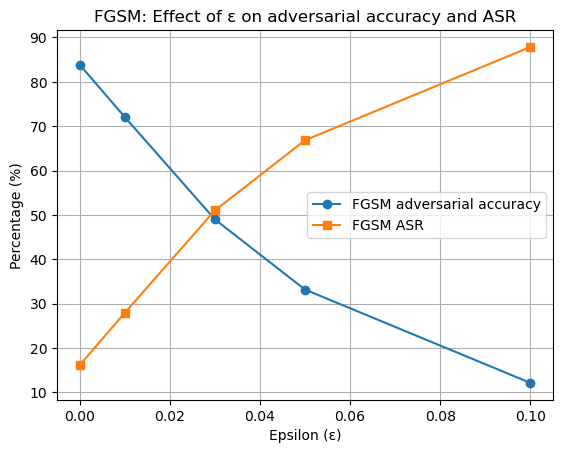

In [10]:
epsilons = [0.0, 0.01, 0.03, 0.05, 0.1]
fgsm_adv_acc_list = []
fgsm_asr_list = []

for eps in epsilons:
    _, adv_acc, asr = evaluate_fgsm_attack(
        model, testloader, device, eps, max_batches=50
    )
    fgsm_adv_acc_list.append(adv_acc)
    fgsm_asr_list.append(asr)

fgsm_adv_acc_percent = [a * 100 for a in fgsm_adv_acc_list]
fgsm_asr_percent = [a * 100 for a in fgsm_asr_list]

plt.figure()
plt.plot(epsilons, fgsm_adv_acc_percent, marker="o", label="FGSM adversarial accuracy")
plt.plot(epsilons, fgsm_asr_percent, marker="s", label="FGSM ASR")
plt.xlabel("Epsilon (ε)")
plt.ylabel("Percentage (%)")
plt.title("FGSM: Effect of ε on adversarial accuracy and ASR")
plt.legend()
plt.grid(True)
plt.show()


## 6. PGD Attack

In [11]:
def pgd_attack(model, images, labels, epsilon, alpha, num_iter):
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    ori_images = images.clone().detach()

    for _ in range(num_iter):
        images.requires_grad = True
        outputs = model(images)
        loss = criterion(outputs, labels)
        model.zero_grad()
        loss.backward()

        grad = images.grad.data
        adv_images = images + alpha * grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-epsilon, max=epsilon)
        images = torch.clamp(ori_images + eta, -2.5, 2.5).detach()

    return images


### 6.1 PGD – Basic Evaluation and ASR

In [12]:
def evaluate_pgd_attack(model, dataloader, device, epsilon, alpha, num_iter, max_batches=None):
    model.eval()
    total = 0
    adv_correct = 0
    misclassified_adv = 0

    batch_count = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        adv_images = pgd_attack(model, images, labels, epsilon, alpha, num_iter)

        with torch.no_grad():
            outputs_adv = model(adv_images)

        _, pred_adv = torch.max(outputs_adv, 1)

        adv_correct += (pred_adv == labels).sum().item()
        misclassified_adv += (pred_adv != labels).sum().item()
        total += labels.size(0)

        batch_count += 1
        if max_batches is not None and batch_count >= max_batches:
            break

    adv_acc = adv_correct / total
    asr = misclassified_adv / total

    print(
        f"PGD  eps = {epsilon:.3f}, alpha = {alpha:.3f}, steps = {num_iter} | "
        f"adv acc: {adv_acc * 100:.2f}% | ASR: {asr * 100:.2f}%"
    )
    return adv_acc, asr

epsilon_pgd = 0.05
alpha_pgd = epsilon_pgd / 4
steps_pgd = 10

pgd_adv_acc, pgd_asr = evaluate_pgd_attack(
    model, testloader, device,
    epsilon=epsilon_pgd,
    alpha=alpha_pgd,
    num_iter=steps_pgd,
    max_batches=50
)


PGD  eps = 0.050, alpha = 0.013, steps = 10 | adv acc: 18.75% | ASR: 81.25%


### 6.2 PGD – Advanced Evaluation (Varying Number of Steps)

PGD  eps = 0.050, alpha = 0.013, steps = 5 | adv acc: 23.22% | ASR: 76.78%
PGD  eps = 0.050, alpha = 0.013, steps = 10 | adv acc: 18.75% | ASR: 81.25%
PGD  eps = 0.050, alpha = 0.013, steps = 20 | adv acc: 17.70% | ASR: 82.30%
PGD  eps = 0.050, alpha = 0.013, steps = 40 | adv acc: 17.45% | ASR: 82.55%


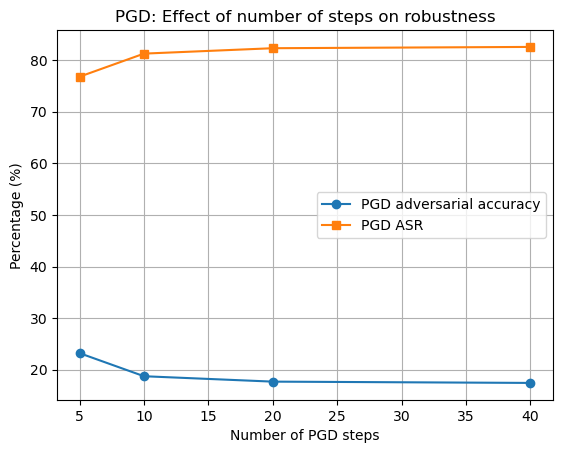

In [13]:
steps_list = [5, 10, 20, 40]
pgd_adv_acc_steps = []
pgd_asr_steps = []

epsilon_pgd = 0.05
alpha_pgd = epsilon_pgd / 4

for steps in steps_list:
    adv_acc, asr = evaluate_pgd_attack(
        model, testloader, device,
        epsilon=epsilon_pgd,
        alpha=alpha_pgd,
        num_iter=steps,
        max_batches=50
    )
    pgd_adv_acc_steps.append(adv_acc)
    pgd_asr_steps.append(asr)

pgd_adv_acc_steps_percent = [a * 100 for a in pgd_adv_acc_steps]
pgd_asr_steps_percent = [a * 100 for a in pgd_asr_steps]

plt.figure()
plt.plot(steps_list, pgd_adv_acc_steps_percent, marker="o", label="PGD adversarial accuracy")
plt.plot(steps_list, pgd_asr_steps_percent, marker="s", label="PGD ASR")
plt.xlabel("Number of PGD steps")
plt.ylabel("Percentage (%)")
plt.title("PGD: Effect of number of steps on robustness")
plt.legend()
plt.grid(True)
plt.show()


## 7. Visual Comparison: Clean vs FGSM vs PGD Images

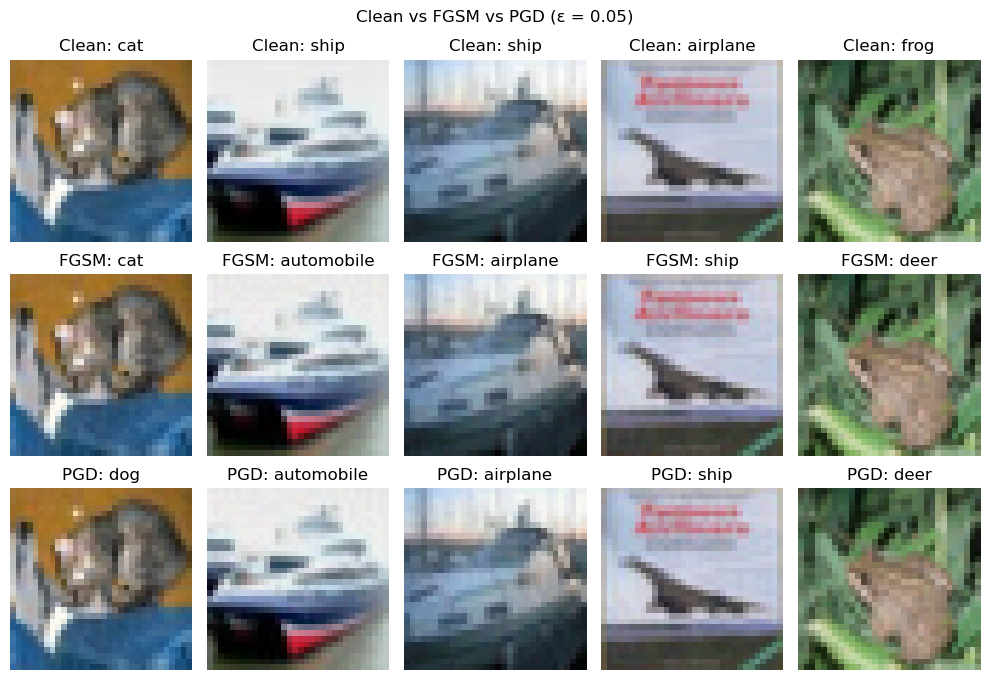

In [14]:
# Inverse normalization for CIFAR-10 (to display images)
inv_normalize = transforms.Normalize(
    mean=[-0.4914 / 0.2023, -0.4822 / 0.1994, -0.4465 / 0.2010],
    std=[1 / 0.2023, 1 / 0.1994, 1 / 0.2010]
)

def to_numpy(img_tensor):
    img = inv_normalize(img_tensor.cpu())
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    return img

# Get one batch
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

epsilon_vis = 0.05
alpha_vis = epsilon_vis / 4
steps_vis = 10

fgsm_images = fgsm_attack(model, images, labels, epsilon_vis)
pgd_images = pgd_attack(model, images, labels, epsilon_vis, alpha_vis, steps_vis)

model.eval()
with torch.no_grad():
    clean_out = model(images)
    fgsm_out = model(fgsm_images)
    pgd_out = model(pgd_images)

_, clean_pred = torch.max(clean_out, 1)
_, fgsm_pred = torch.max(fgsm_out, 1)
_, pgd_pred = torch.max(pgd_out, 1)

num_examples = 5
plt.figure(figsize=(10, 7))

for i in range(num_examples):
    # Clean
    plt.subplot(3, num_examples, i + 1)
    plt.imshow(to_numpy(images[i]))
    plt.title(f"Clean: {class_names[clean_pred[i]]}")
    plt.axis("off")

    # FGSM
    plt.subplot(3, num_examples, i + 1 + num_examples)
    plt.imshow(to_numpy(fgsm_images[i]))
    plt.title(f"FGSM: {class_names[fgsm_pred[i]]}")
    plt.axis("off")

    # PGD
    plt.subplot(3, num_examples, i + 1 + 2 * num_examples)
    plt.imshow(to_numpy(pgd_images[i]))
    plt.title(f"PGD: {class_names[pgd_pred[i]]}")
    plt.axis("off")

plt.suptitle("Clean vs FGSM vs PGD (ε = {:.2f})".format(epsilon_vis))
plt.tight_layout()
plt.show()


## 8. Summary and Observations

- The **clean test accuracy** reflects how well the CNN performs without any attacks.
- **FGSM** introduces a single-step perturbation in the direction of the gradient sign.
  As ε increases, adversarial accuracy decreases and **ASR increases**.
- **PGD** performs multiple small FGSM-like steps and is typically a **stronger attack**.
  Increasing the number of PGD iterations generally reduces adversarial accuracy further
  and increases ASR.
- Visually, adversarial images often look very similar to clean ones to humans, yet the
  model’s predictions change, illustrating the vulnerability of neural networks to small,
  carefully crafted perturbations.


In [15]:
# Store FGSM adversarial images for visualization
fgsm_results = {}
for eps in epsilons:
    model.eval()
    adv_list = []
    for i in range(10):
        img, label = testset[i]
        img = img.unsqueeze(0).to(device)
        label = torch.tensor([label]).to(device)
        adv = fgsm_attack(model, img, label, eps)
        adv_list.append(adv.squeeze(0).cpu())
    fgsm_results[eps] = adv_list


In [16]:
# Store PGD adversarial images for visualization
pgd_results = {}
for eps in epsilons:
    model.eval()
    adv_list = []
    alpha = eps / 4
    for i in range(10):
        img, label = testset[i]
        img = img.unsqueeze(0).to(device)
        label = torch.tensor([label]).to(device)
        adv = pgd_attack(model, img, label, eps, alpha, num_iter=10)
        adv_list.append(adv.squeeze(0).cpu())
    pgd_results[eps] = adv_list


Side-by-side Clean vs FGSM vs PGD Grid:


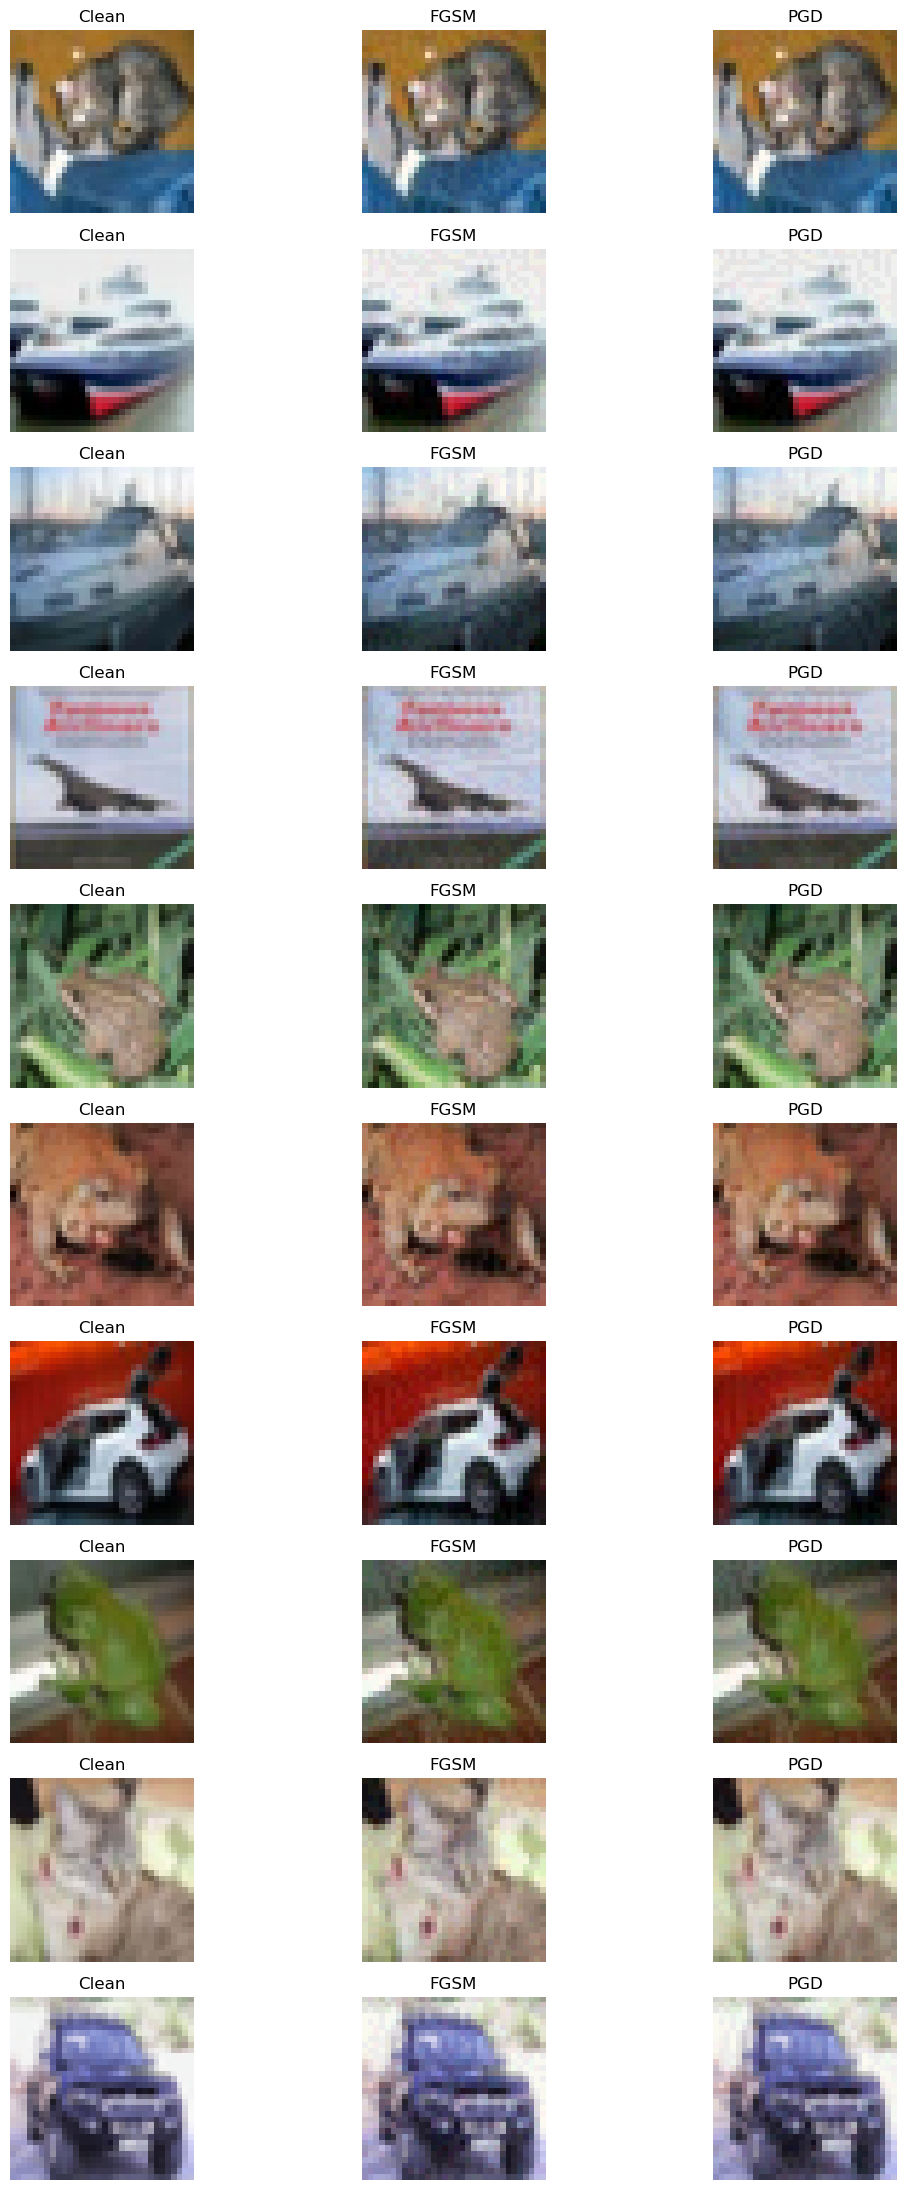

In [17]:
# Side-by-side Clean vs FGSM vs PGD grid
eps_show = 0.1
orig_batch = torch.stack([testset[i][0] for i in range(10)])
fgsm_batch = fgsm_results[eps_show][:10]
pgd_batch  = pgd_results[eps_show][:10]

def show_side_by_side(orig_batch, fgsm_batch, pgd_batch, n=10):
    plt.figure(figsize=(12, n*2.2))
    for i in range(n):
        plt.subplot(n, 3, i*3 + 1)
        plt.imshow(to_numpy(orig_batch[i])); plt.title("Clean"); plt.axis("off")
        plt.subplot(n, 3, i*3 + 2)
        plt.imshow(to_numpy(fgsm_batch[i])); plt.title("FGSM"); plt.axis("off")
        plt.subplot(n, 3, i*3 + 3)
        plt.imshow(to_numpy(pgd_batch[i])); plt.title("PGD"); plt.axis("off")
    plt.tight_layout(); plt.show()

print("Side-by-side Clean vs FGSM vs PGD Grid:")
show_side_by_side(orig_batch, fgsm_batch, pgd_batch, n=10)


3-row combined grid:


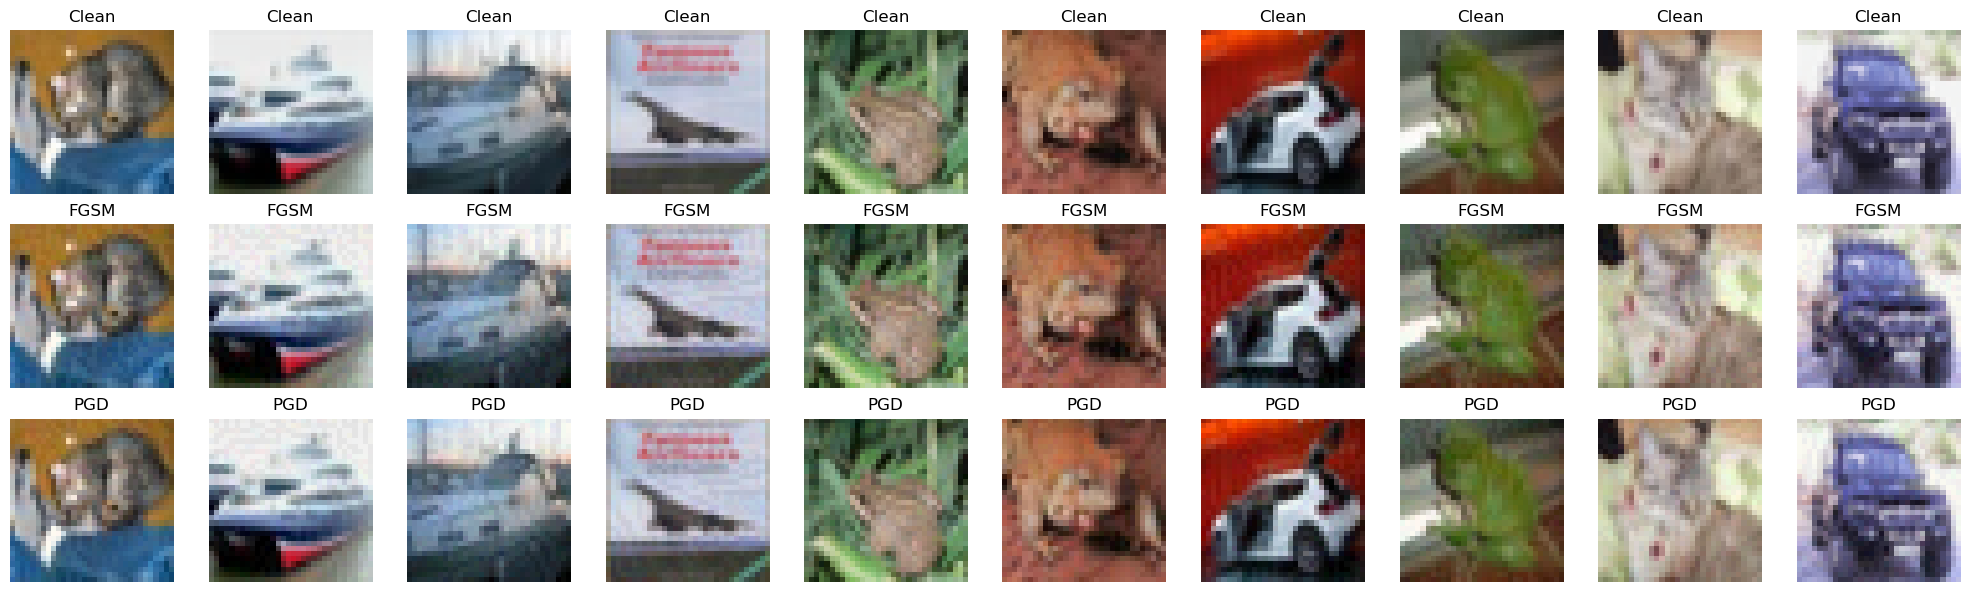

In [18]:
# 3-row combined grid
def show_three_row_grid(orig_batch, fgsm_batch, pgd_batch, n=10):
    plt.figure(figsize=(n*2, 6))
    for i in range(n):
        plt.subplot(3, n, i+1)
        plt.imshow(to_numpy(orig_batch[i])); plt.title("Clean"); plt.axis("off")
    for i in range(n):
        plt.subplot(3, n, n + i + 1)
        plt.imshow(to_numpy(fgsm_batch[i])); plt.title("FGSM"); plt.axis("off")
    for i in range(n):
        plt.subplot(3, n, 2*n + i + 1)
        plt.imshow(to_numpy(pgd_batch[i])); plt.title("PGD"); plt.axis("off")
    plt.tight_layout(); plt.show()

print("3-row combined grid:")
show_three_row_grid(orig_batch, fgsm_batch, pgd_batch, n=10)


FGSM Heatmap


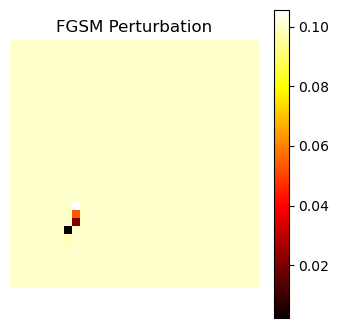

PGD Heatmap


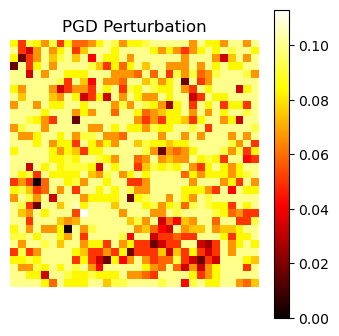

In [19]:
# Heatmaps for FGSM & PGD
def show_heatmap(orig, adv, title):
    diff = (adv - orig).detach().cpu().numpy()
    diff = np.abs(diff).mean(axis=0)
    plt.figure(figsize=(4,4))
    plt.imshow(diff, cmap='hot')
    plt.colorbar()
    plt.title(title)
    plt.axis("off")
    plt.show()

idx = 0
orig = testset[idx][0].unsqueeze(0).to(device)
adv_fgsm = fgsm_results[eps_show][idx].unsqueeze(0).to(device)
adv_pgd  = pgd_results[eps_show][idx].unsqueeze(0).to(device)

print("FGSM Heatmap")
show_heatmap(orig[0], adv_fgsm[0], "FGSM Perturbation")
print("PGD Heatmap")
show_heatmap(orig[0], adv_pgd[0], "PGD Perturbation")
